## **Etude pratique: le chemin des deneigeuses**

### **1 - Les import**
Dans ce fichier, nous utilisons 4 librairies. Deux sont utilisées pour le parcours du drone. **`osnmx`** pour générer le graph à partir d'une ville ou d'un quartier et **`networkX`** pour le traitement du graphe. 

La librairie **`datetime`** est utilisée pour calculer le temps d'éxécution de notre code et enfin **`colorama`** pour l'affichage graphique des informations.

In [8]:
import osmnx as ox
import networkx as nx
import datetime
from colorama import Fore, Style

### **2 - Fonction d'appel**
La fonction `loadingGraph` prend en paramètre _`neighborhood`_ le quartier, _`city`_ la ville, _`country`_ le pays et _`road_type`_, elle permet de charger le graphe.
Pour ce qui est des paramètres completion et maps il s'agit de flag permettant d'afficher respectivement le niveau de
couverture du graphe par les deneigeuses et les trajets que vont parcourir les deneigeuses.
Nous aborderons l'intérêt des trois derniers paramètres dans la fonction `find_critical`.

In [9]:
def main(neighborhood, city, country, road_type, required_len_pull, required_len, min_accuracy, completion, maps):
    if (neighborhood):
        G = ox.graph_from_place(neighborhood + ", " + city + ", " + country, network_type=road_type, simplify=True)
    else:
        G = ox.graph_from_place(city + ", " + country, network_type=road_type, simplify=True)
    G = nx.convert_node_labels_to_integers(G)
    list_ = []
    path = dict(nx.all_pairs_shortest_path(G))
    all_path = create_path_pull(path, required_len)
    res_path = find_critical_road(G, path, all_path, min_accuracy, required_len, completion, maps)

### **3 - Création des chemins**
La fonction `create_path_pull` prend en paramètre _`path`_ le dictionnaire contenant tout les shortest path du graph et _`required_len`_ qui permet de selectionner par la longueur les chemins que nous allons attribuer à nos deneigeuses plus tard dans la suite du code.

In [10]:
def create_path_pull(path, required_len):
    all_path = []
    for elem in path.values():
        for var in elem.values():
            if len(var) > required_len:
                all_path.append(var)
    return all_path

### **4 - Détermination de la rentabilité**
Il s'agit de la première sous fonction utilisée dans la fonction `find_critical_road`. L'objectif de cette fonction est de determiné la pertinence d'un chemin par rapport aux sommets que nous avons déjà visité. L'objectif étant de minimiser le nombre de fois ou nous allons repasser par des sommets que nous avons visité tout en maximisant la longueur de nos vecteurs.

In [11]:
def rentability(checked_mat, need_to_happend):
    res = 0
    for elem in need_to_happend:
        if checked_mat[elem] != 1:
            res+=1
    return res/len(need_to_happend)

### **5 - Mise à jour du vecteur de parcours**
Tout comme précedemment, il s'agit d'une sous fonction utilisée dans la fonction `find_critical_road`. L'objectif de la fonction est de mettre a jour la liste des sommets par rapport au chemin que nous venons d'ajouter dans a liste de nos chemins finaux. Si jamais un nouveau sommet est rencontré on passe la valeur contenu à son index a True.

In [12]:
def update(checked_mat, res_path):
    for elem in res_path:
        if checked_mat[elem] != True:
            checked_mat[elem] = True
    return checked_mat

### **6 - Fonction de recherches des chemins**
Il s'agit de la fonction général permettant d'obtenir la liste des chemins que nos deneigeuses vont devoir parcourir. La fonction prend en paramètre _`G_` le graphe orienté, _`path_` le dictionnaire, _`all`_ _`path`_ la liste de chemins retenus que nou sallons traiter, _`min_accuracy`_ et _`required_len`_ sont des constantes que l'utilisateur passe en paramètre nous détaillerons leurs fonctionnement plus tard, et enfin les deux booléens correspondant au options de print.
La fonction va donc passer à travers le vecteur contenant tout les plus courts chemins que nous avons retenus dans la fonction create_path_pull. 
 Pour cela on fixe au départ deux constantes min_accuracy et required_len, ces variables vont nous permettre de selectionner au départ le type de vecteur que nous allons conserver. Prenons le cas d'Outremont pour les routes, comme nous savons que le graphe va être relativement grand nous allons choisir d'intégrer des vecteurs au départ dont la taille minimale est de 15 sommets. La raison étant que nous allons chercher à éliminer le plus de noeuds possible au départ, parallèlement à cela nous allons choisir un degré de précision de 0.9. A la fin de la première itération les poids et les longueurs de vecteurs seront recalculer de manière à trouver les derniers sommets que nous n'aurions pas encore visités. De cette façon nous assuront une pertinence relativement élevé des chemins et des longueurs réalistes par rapport à la taille de la liste.

In [53]:
def find_critical_road(G, path, all_path, min_accuracy, required_len, completion, maps):
    checked_mat = [False] * len(path.values())
    
    #niveau de précision demandé à la première itération
    critical_floor = min_accuracy
    #longueur minimale de chaque chemin à la première itération
    acceptable_len = required_len
    
    critical_road = []
    length = len(all_path) - 1
    i = 0
    final = []
    while False in checked_mat:
        if i > length:
            i = 0
            #Ici la précision et la longueur acceptable des chemins est modifié de manière a ne pas
            #tomber dans un creu et que nous puissions trouver les sommets que nous n'avons pas encore traverser
            #quitte à repasser sur des sommets que nous avons déjàn visité 
            critical_floor -= 0.05
            acceptable_len -= 1
            if completion:
                formatted_float = "{:.2f}".format(checked_mat.count(True)*100/len(checked_mat))
                print("The complete cover is at : " + Fore.BLUE + Style.BRIGHT + formatted_float + Style.RESET_ALL + "% of its completion")
        if len(all_path[i]) > acceptable_len:
            if rentability(checked_mat, all_path[i]) > critical_floor:
                critical_road.append(all_path[i])
                if maps:
                    final.append(all_path[i])
                checked_mat = update(checked_mat, all_path[i])
        i+=1
    colors = ['r', 'b', 'g', 'c', 'y', "m", "w"]
    used_colors = []
    j = 0
    for i in range(len(final)):
        if (j == len(colors)):
            j = 0
        used_colors.append(colors[j])
        j += 1
    fig, ax = ox.plot_graph_routes(G, final, used_colors, route_linewidth=8, node_size=1, bgcolor='k')
    return critical_road

Beginning path calculation for roads
The complete cover is at : 43.80% of its completion
The complete cover is at : 55.37% of its completion
The complete cover is at : 55.37% of its completion
The complete cover is at : 55.37% of its completion
The complete cover is at : 55.37% of its completion
The complete cover is at : 64.46% of its completion
The complete cover is at : 64.46% of its completion
The complete cover is at : 69.01% of its completion
The complete cover is at : 75.62% of its completion
The complete cover is at : 75.62% of its completion
The complete cover is at : 78.51% of its completion
The complete cover is at : 83.47% of its completion
The complete cover is at : 85.54% of its completion
The complete cover is at : 88.84% of its completion
The complete cover is at : 90.50% of its completion
The complete cover is at : 94.21% of its completion
The complete cover is at : 99.17% of its completion


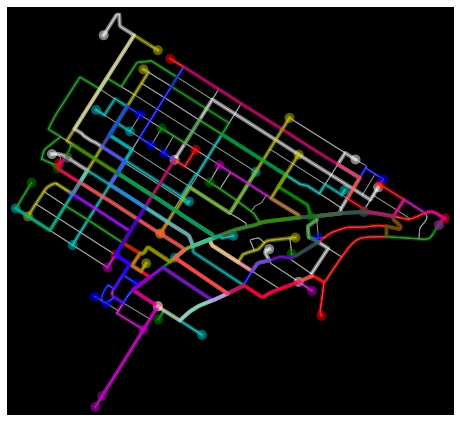

Beginning path calculation for sidewalks
The complete cover is at : 35.08% of its completion
The complete cover is at : 45.75% of its completion
The complete cover is at : 48.58% of its completion
The complete cover is at : 52.51% of its completion
The complete cover is at : 53.81% of its completion
The complete cover is at : 57.73% of its completion
The complete cover is at : 61.00% of its completion
The complete cover is at : 64.05% of its completion
The complete cover is at : 70.48% of its completion
The complete cover is at : 70.48% of its completion
The complete cover is at : 72.77% of its completion
The complete cover is at : 76.69% of its completion
The complete cover is at : 81.59% of its completion
The complete cover is at : 87.69% of its completion
The complete cover is at : 89.98% of its completion
The complete cover is at : 93.90% of its completion
The complete cover is at : 98.91% of its completion


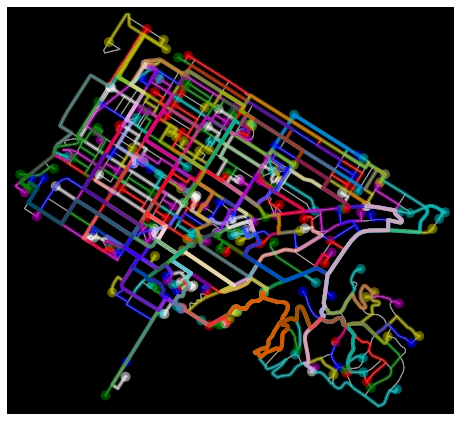

In [54]:
print(Fore.RED + Style.BRIGHT + "Beginning path calculation for roads" + Style.RESET_ALL)
main("Outremont","Montreal", "Canada", "drive" , 4, 15, 0.9, True, True)
print(Fore.RED + Style.BRIGHT + "Beginning path calculation for sidewalks" + Style.RESET_ALL)
main("Outremont","Montreal", "Canada", "walk" , 4, 15, 0.9, True, True)